# Extraction of features

In this script, we will look into movements within trials and extract some features that could be informative about effort.

The possible features of interest:
- duration of movement
- peaks and their amplitude - in movement, speed, acceleration
- number of peaks, ie., number of submovements
- intermittency
- gesture space


# Folder setting

In [62]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

curfolder = os.getcwd()
mergedfolder = curfolder + "\\TS_merged\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")

# for now we can keep only 0_2 in the list
filestotrack = [x for x in filestotrack if "0_2_" in x]

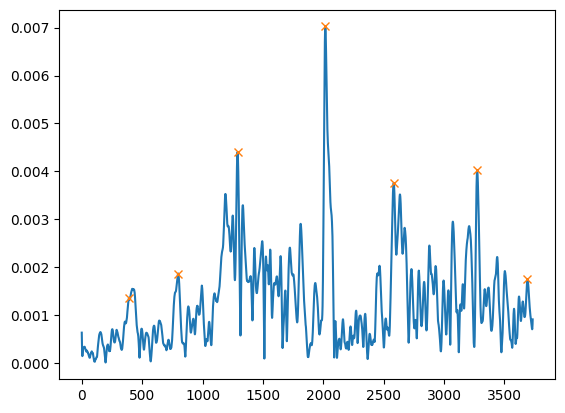

In [46]:
sample = filestotrack[20]
df = pd.read_csv(sample)


# find peaks with height of mean + 2*std
peaks, _ = find_peaks(df["COPc"], height=df["COPc"].mean(), distance=400)

# find the values of the peaks
peaks_values = df.loc[peaks, "COPc"]

x = df['COPc']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

In [67]:
sample = filestotrack[100]
df = pd.read_csv(sample)
df

,time,left_back,right_forward,right_back,left_forward,COPXc,COPYc,COPc,TrialID,FileInfo,...,RSmallToe_speed,LWrist_speed,LWrist_vert_vel,f0,vocalization,upper_body,arms,lower_body,head_mov,movement_in_trial
0,0.0,1.139631,0.773826,1.533191,1.348930,0.000581,0.000199,0.000614,0_2_100_p1,p1_zwaar_geluiden_c2,...,0.655561,7.227067,5.124194,NaN,silent,nomovement,nomovement,nomovement,nomovement,nomovement
1,2.0,1.139429,0.774251,1.533127,1.348561,0.000515,0.000187,0.000548,0_2_100_p1,p1_zwaar_geluiden_c2,...,0.665293,7.233171,5.063755,NaN,silent,nomovement,nomovement,nomovement,nomovement,nomovement
2,4.0,1.139222,0.774539,1.533052,1.348257,0.000451,0.000173,0.000483,0_2_100_p1,p1_zwaar_geluiden_c2,...,0.675025,7.239276,5.003316,NaN,silent,nomovement,nomovement,nomovement,nomovement,nomovement
3,6.0,1.139016,0.774711,1.532973,1.348008,0.000390,0.000155,0.000420,0_2_100_p1,p1_zwaar_geluiden_c2,...,0.684758,7.245380,4.942877,NaN,silent,nomovement,nomovement,nomovement,nomovement,nomovement
4,8.0,1.138812,0.774789,1.532892,1.347808,0.000333,0.000136,0.000359,0_2_100_p1,p1_zwaar_geluiden_c2,...,0.694490,7.251484,4.882438,NaN,silent,nomovement,nomovement,nomovement,nomovement,nomovement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,6654.0,1.182995,0.743770,1.562112,1.329701,-0.000200,0.000862,0.000885,0_2_100_p1,p1_zwaar_geluiden_c2,...,1.120514,7.543869,1.979030,NaN,silent,nomovement,nomovement,nomovement,movement,nomovement
3328,6656.0,1.182848,0.743952,1.561939,1.330046,-0.000182,0.000852,0.000871,0_2_100_p1,p1_zwaar_geluiden_c2,...,1.095955,7.547331,1.983126,NaN,silent,nomovement,nomovement,nomovement,movement,nomovement
3329,6658.0,1.182722,0.744164,1.561780,1.330384,-0.000158,0.000837,0.000851,0_2_100_p1,p1_zwaar_geluiden_c2,...,1.071395,7.550793,1.987222,NaN,silent,nomovement,nomovement,nomovement,movement,nomovement
3330,6660.0,1.182621,0.744410,1.561636,1.330708,-0.000127,0.000814,0.000824,0_2_100_p1,p1_zwaar_geluiden_c2,...,1.046835,7.554255,1.991318,NaN,silent,nomovement,nomovement,nomovement,movement,nomovement


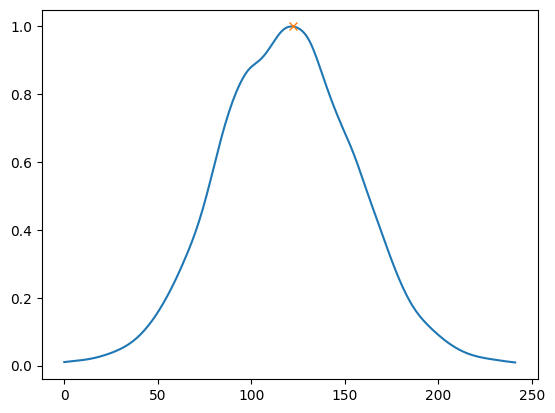

In [73]:
sample = filestotrack[6]
df = pd.read_csv(sample)

# get only sudf in which vocalization is to sounding
subdf = df[df["vocalization"] == "sounding"]
# reset index
subdf = subdf.reset_index(drop=True)

# find peaks with height of mean + 2*std
peaks, _ = find_peaks(subdf["envelope"], height=df["envelope"].mean(), distance=200)

# find the values of the peaks
peaks_values = subdf.loc[peaks, "envelope"]

x = subdf['envelope']
plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()

In [90]:
features_df = pd.DataFrame()

for file in filestotrack:
    print('working on file: ', file)
    df = pd.read_csv(file)
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)
    subdf = df[df["movement_in_trial"] == "movement"]
    # check if there is any movement in the trial
    if subdf.shape[0] > 0:
        ### duration
        duration_mov = subdf["time"].iloc[-1] - subdf["time"].iloc[0]
    else:
        duration_mov = 0

    ### peaks in COP
    cop_peaks_ind, _ = find_peaks(df["COPc"], height=df["COPc"].mean(), distance=400)
    cop_peaks_values = df.loc[cop_peaks_ind, "COPc"]
    cop_peaks_values = cop_peaks_values.tolist()
    # get the time of the peaks
    cop_peaks_time = df.loc[cop_peaks_ind, "time"]
    cop_peaks_time = cop_peaks_time.tolist()

    ### peaks in envelope
    # check whether column vocalization exist
    if "vocalization" not in df.columns:
        print("No vocalization column in the dataframe")
        continue
    else:
        subdf = df[df["vocalization"] == "sounding"]
        # reset index
        subdf = subdf.reset_index(drop=True)

        if subdf.shape[0] > 0:
            # duration
            duration_voc = subdf["time"].iloc[-1] - subdf["time"].iloc[0]
            print(duration_voc)
            # env peaks
            envelope_peaks_ind, _ = find_peaks(subdf["envelope"], height=df["envelope"].mean(), distance=200)
            envelope_peaks_values = df.loc[envelope_peaks_ind, "envelope"]
            envelope_peaks_values = envelope_peaks_values.tolist()
            # get the times
            envelope_peaks_time = subdf.loc[envelope_peaks_ind, "time"]
        else:
            duration_voc = 0
            envelope_peaks_values = []
            envelope_peaks_time = []


    # creta a new row with duration, concept, modality and correction
    newrow = pd.DataFrame({"duration_m": [duration_mov], "duration_v": [duration_voc], 'cop_peaks': [cop_peaks_values], 'cop_peaks_t': [cop_peaks_time], 'env_peaks': [envelope_peaks_values], "concept": [df["concept"].iloc[0]], "modality": [df["modality"].iloc[0]], "correction": [df["correction"].iloc[0]], 'TrialID': [df['TrialID'].iloc[0]]})
    
    # concat
    features_df = pd.concat([features_df, newrow], ignore_index=True)

    

working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_111_p1.csv
2574.0
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_112_p1.csv
2510.0
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_0_p0.csv
No vocalization column in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_1_p0.csv
No vocalization column in the dataframe
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_2_p0.csv
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_3_p0.csv
118.0
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_4_p0.csv
482.0
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_5_p0.csv
856.0
working on file:  e:\FLESH_ContinuousBodilyEffort\TS_processing\TS_merged\merged_anno_0_2_6_

In [91]:
features_df

,duration_m,duration_v,cop_peaks,cop_peaks_t,env_peaks,concept,modality,correction,TrialID
0,2248.0,2574.0,"[0.0082492853562105, 0.0038285001891382, 0.001...","[1766.0, 3068.0, 3938.0]","[0.0211731104997838, 0.0236334418304758]",ziek,geluiden,c0,0_2_111_p1
1,3864.0,2510.0,"[0.0025037981553558, 0.0029753849782105, 0.002...","[248.0, 1442.0, 2316.0, 3224.0, 4156.0]","[0.0294051418178129, 0.7391733460302075, 0.257...",ziek,geluiden,c1,0_2_112_p1
2,5948.0,0.0,"[0.003822570621258, 0.002582661431982, 0.00392...","[520.0, 2640.0, 3500.0, 4620.0, 5794.0]",[],vrouw,combinatie,c0,0_2_2_p0
3,1866.0,118.0,"[0.0025776949772729, 0.0032208283496538]","[246.0, 1304.0]",[0.0376029241410593],vrouw,combinatie,c1,0_2_3_p0
4,5748.0,482.0,"[0.0011712304374483, 0.0011640659828011, 0.002...","[2222.0, 3574.0, 4956.0, 5874.0, 6886.0, 8136....",[0.0009559011892058],vrouw,combinatie,c2,0_2_4_p0
...,...,...,...,...,...,...,...,...,...
82,1348.0,3064.0,"[0.0028004743687745, 0.00166151003214, 0.00512...","[1156.0, 2684.0, 3516.0, 4452.0, 5612.0]","[0.0125619068228424, 0.050945371356372, 0.0123...",zuigen,geluiden,c2,0_2_107_p1
83,2452.0,2090.0,"[0.0021608663781204, 0.0017696458533487, 0.002...","[468.0, 1310.0, 2268.0, 3184.0, 3994.0, 4820.0]","[0.0237388426040095, 0.0237368978546421, 0.023...",dik,geluiden,c0,0_2_108_p1
84,5398.0,4284.0,"[0.0012667972403353, 0.006139062012253, 0.0066...","[382.0, 2402.0, 3216.0, 4094.0, 5406.0]","[0.018864262464822, 0.6842391498494158, 0.0188...",dik,geluiden,c1,0_2_109_p1
85,5030.0,4422.0,"[0.0037668211350997, 0.0035785633115683, 0.002...","[1370.0, 2424.0, 3594.0, 5168.0, 6260.0]","[0.0294051317061562, 0.029405421256146, 0.0288...",dik,geluiden,c2,0_2_110_p1


In [80]:
# we need to create a concept id to group together corrections of one concept

for row in features_df.iterrows():
    row = row[1]
    features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]


In [81]:
# which concept_id has in correction only c0, but not c1 and c2

c0 = features_df[features_df["correction"] == "c0"]["concept_id"].unique()
c1 = features_df[features_df["correction"] == "c1"]["concept_id"].unique()
c2 = features_df[features_df["correction"] == "c2"]["concept_id"].unique()

In [82]:
# which concept_id is only in c0
only_c0 = [x for x in c0 if x not in c1 and x not in c2]
print(only_c0)
c0_c1 = [x for x in c0 if x in c1 and x not in c2]
print(c0_c1)
all_c = [x for x in c0 if x in c1 and x in c2]
print(all_c)

['ik_combinatie_p0', 'kauwen_combinatie_p0', 'vis_combinatie_p1', 'ruiken_combinatie_p1', 'wind_combinatie_p1', 'vogel_gebaren_p0', 'vuur_gebaren_p0', 'horen_gebaren_p0', 'blazen_gebaren_p1', 'kat_gebaren_p1', 'lachen_gebaren_p1', 'slapen_gebaren_p1', 'vallen_geluiden_p0', 'grommen_geluiden_p1', 'huilen_geluiden_p1']
['ziek_geluiden_p1', 'goed_gebaren_p0', 'geven_gebaren_p1']
['vrouw_combinatie_p0', 'verbranden_combinatie_p0', 'vliegen_combinatie_p0', 'misschien_combinatie_p0', 'bliksem_combinatie_p0', 'groot_combinatie_p1', 'hoog_combinatie_p1', 'blij_combinatie_p1', 'heet_combinatie_p1', 'water_gebaren_p0', 'ver_gebaren_p0', 'zoet_gebaren_p1', 'geur_geluiden_p0', 'vlieg_geluiden_p0', 'scherp_geluiden_p0', 'staart_geluiden_p0', 'piepen_geluiden_p0', 'jagen_geluiden_p0', 'zwaar_geluiden_p1', 'zout_geluiden_p1', 'zuigen_geluiden_p1', 'dik_geluiden_p1']


In [83]:
# make subf from features_df with concept_ids that are in all_c

subfeat3 = features_df[features_df["concept_id"].isin(all_c)]
subfeat2 = features_df[features_df["concept_id"].isin(c0_c1)]

In [85]:
subfeat3

,duration,duration_m,duration_v,cop_peaks,cop_peaks_t,env_peaks,concept,modality,correction,TrialID,concept_id
2,NaN,5948.0,0.0,"[0.003822570621258, 0.002582661431982, 0.00392...","[520.0, 2640.0, 3500.0, 4620.0, 5794.0]",[],vrouw,combinatie,c0,0_2_2_p0,vrouw_combinatie_p0
3,NaN,1866.0,118.0,"[0.0025776949772729, 0.0032208283496538]","[246.0, 1304.0]",[0.0376029241410593],vrouw,combinatie,c1,0_2_3_p0,vrouw_combinatie_p0
4,NaN,5748.0,482.0,"[0.0011712304374483, 0.0011640659828011, 0.002...","[2222.0, 3574.0, 4956.0, 5874.0, 6886.0, 8136....",[0.0009559011892058],vrouw,combinatie,c2,0_2_4_p0,vrouw_combinatie_p0
5,NaN,2298.0,856.0,"[0.01872510313493, 0.0092551708621125]","[1160.0, 2008.0]",[0.0194208578230664],verbranden,combinatie,c0,0_2_5_p0,verbranden_combinatie_p0
6,NaN,3882.0,2088.0,"[0.0016699225362733, 0.007316258262624, 0.0010...","[1400.0, 2464.0, 3456.0, 4402.0, 5264.0]","[0.0096731917088983, 0.0096836970660094]",verbranden,combinatie,c1,0_2_6_p0,verbranden_combinatie_p0
...,...,...,...,...,...,...,...,...,...,...,...
81,NaN,1182.0,1524.0,"[0.0022166424963387, 0.0014433181063763]","[714.0, 2766.0]","[0.005231002837604, 0.2922042505949573, 0.0033...",zuigen,geluiden,c1,0_2_106_p1,zuigen_geluiden_p1
82,NaN,1348.0,3064.0,"[0.0028004743687745, 0.00166151003214, 0.00512...","[1156.0, 2684.0, 3516.0, 4452.0, 5612.0]","[0.0125619068228424, 0.050945371356372, 0.0123...",zuigen,geluiden,c2,0_2_107_p1,zuigen_geluiden_p1
83,NaN,2452.0,2090.0,"[0.0021608663781204, 0.0017696458533487, 0.002...","[468.0, 1310.0, 2268.0, 3184.0, 3994.0, 4820.0]","[0.0237388426040095, 0.0237368978546421, 0.023...",dik,geluiden,c0,0_2_108_p1,dik_geluiden_p1
84,NaN,5398.0,4284.0,"[0.0012667972403353, 0.006139062012253, 0.0066...","[382.0, 2402.0, 3216.0, 4094.0, 5406.0]","[0.018864262464822, 0.6842391498494158, 0.0188...",dik,geluiden,c1,0_2_109_p1,dik_geluiden_p1


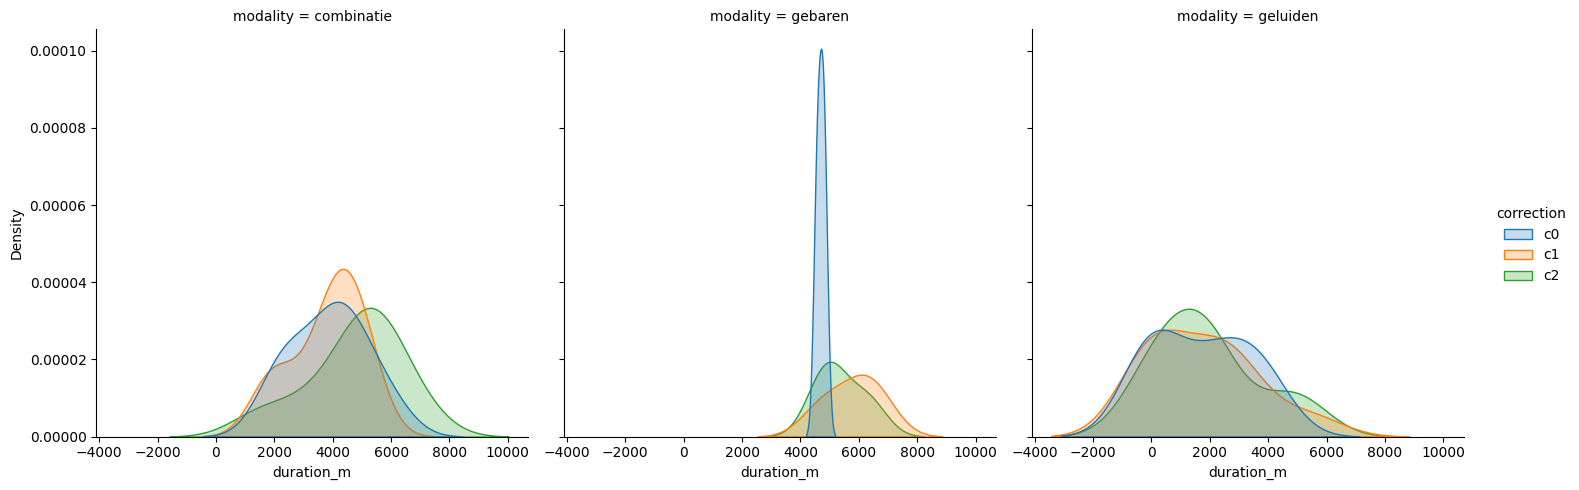

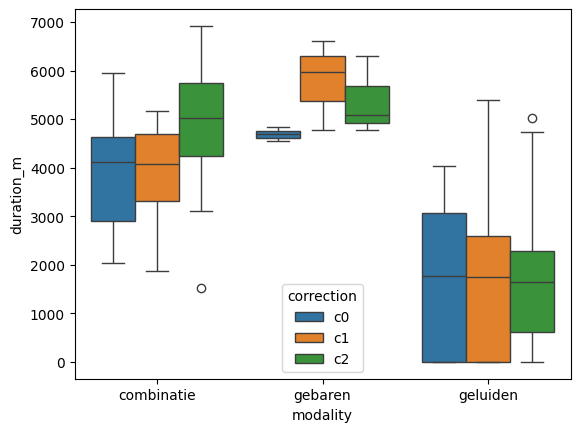

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt


### plotting duration as distribution
sns.displot(subfeat3, x="duration_m", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

### plotting duration as boxplots
sns.boxplot(data=subfeat3, x="modality", y="duration_m", hue="correction")
plt.show()


C:\Users\kadava\AppData\Local\Temp\ipykernel_1072\4269772643.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(subfeat3, x="duration_v", col='modality', hue="correction", kind="kde", fill=True)


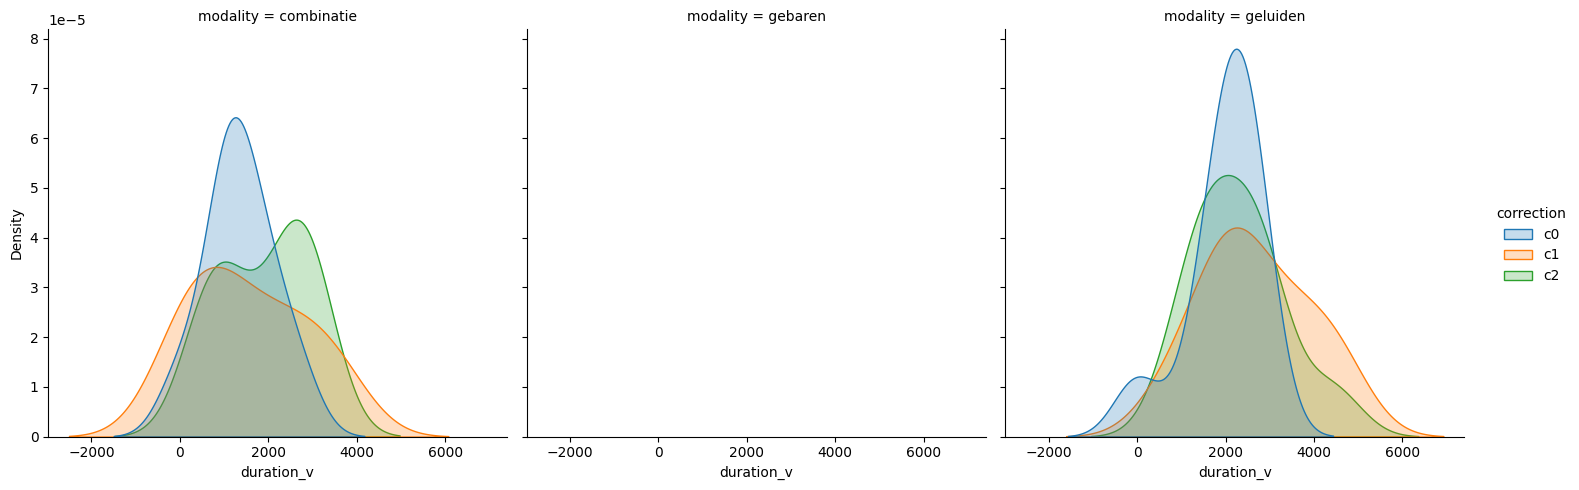

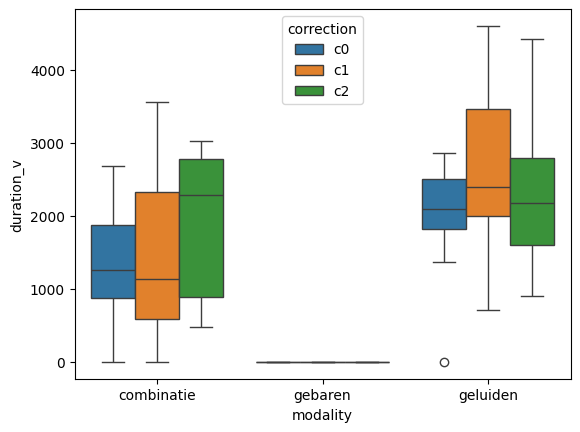

In [96]:
### plotting vocalization duration
sns.displot(subfeat3, x="duration_v", col='modality', hue="correction", kind="kde", fill=True)
plt.show()

### plotting vocalization duration as boxplots
sns.boxplot(data=subfeat3, x="modality", y="duration_v", hue="correction")
plt.show()

So it seems that in the unimodal conditions, the corrections (at least as long as difference between c0 and c1 is concerned) are longer in duration. This does not apply for multimodal condition

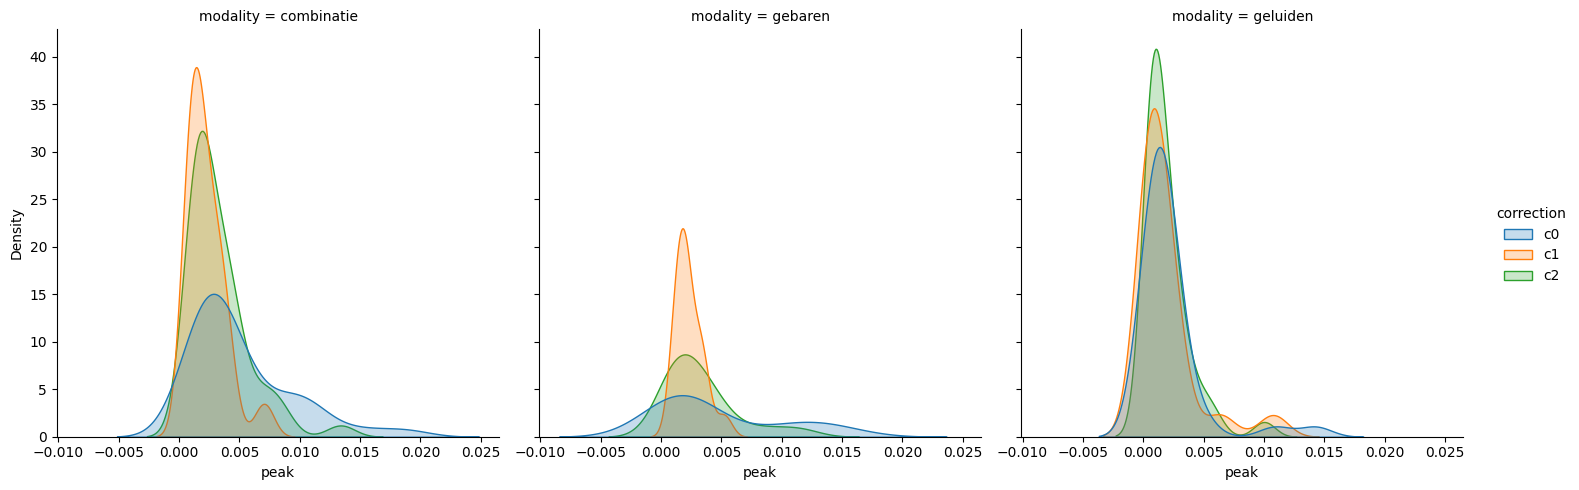

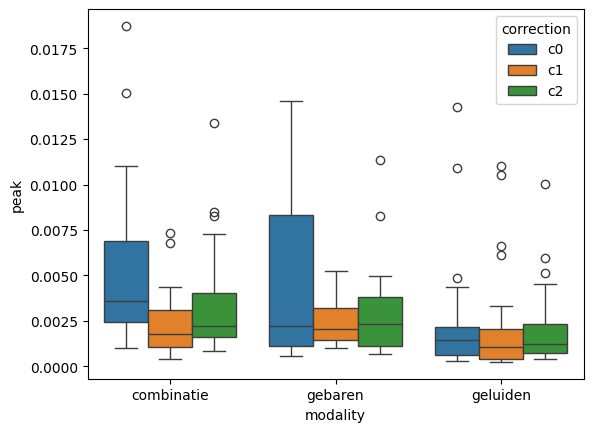

In [98]:
### plotting peaks in COPc

flat_data = []

for _, row in subfeat3.iterrows():
    for peak in row['cop_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# get rid of outliers based on Tukey's fences
# Q1 = flat_df["peak"].quantile(0.25)
# Q3 = flat_df["peak"].quantile(0.75)
# IQR = Q3 - Q1
# flat_df = flat_df[(flat_df["peak"] > (Q1 - 1.5 * IQR)) & (flat_df["peak"] < (Q3 + 1.5 * IQR))]

# plot 
sns.displot(flat_df, x="peak", col="modality", hue='correction', kind="kde", fill=True)
plt.show()

# plot boxplots
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
plt.show()


Here in movement conditions (combinatie, gebaren), we see that there are high peaks in COP especially for the c0 trials.

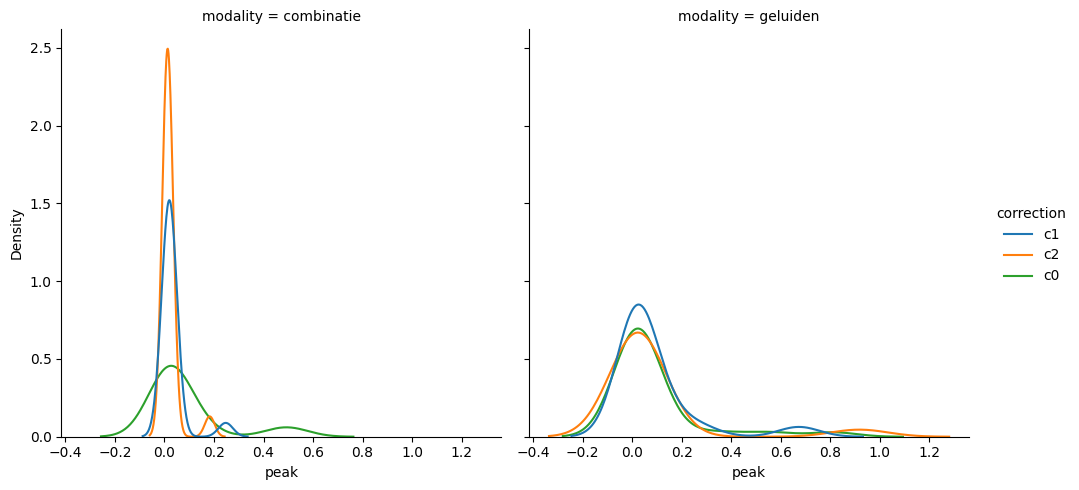

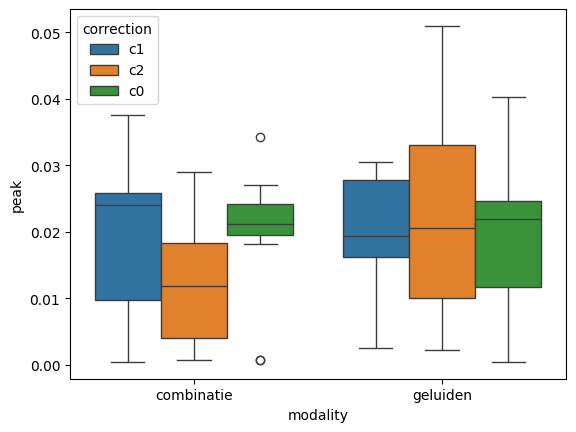

In [101]:
### plotting peaks in envelope

flat_data = []

for _, row in subfeat3.iterrows():
    for peak in row['env_peaks']:
        flat_data.append({"TrialID": row["TrialID"], "concept": row["concept"], "modality": row["modality"], "correction": row["correction"], "peak": peak})

flat_df = pd.DataFrame(flat_data)

# plot each modality separately in a grid, hue by correction
sns.displot(flat_df, x="peak", col="modality", hue="correction", kind="kde")
plt.show()

# get rid of outliers based on Tukey's fences
Q1 = flat_df["peak"].quantile(0.25)
Q3 = flat_df["peak"].quantile(0.75)
IQR = Q3 - Q1
flat_df = flat_df[(flat_df["peak"] > (Q1 - 1.5 * IQR)) & (flat_df["peak"] < (Q3 + 1.5 * IQR))]
                  
# plot boxplots
sns.boxplot(data=flat_df, x="modality", y="peak", hue="correction")
plt.show()

## function for intermittency (smoothnes), from Wim's paper

In [ ]:
# #dimensionless smoothness measure
# smooth.get <- function(velocity) #Hogan & Sternad formula
# {
#   if(!all(velocity ==0))
#   {
#   velocity <- as.vector(scale(velocity))
#   acceleration <- butter.it(diff(velocity))
#   jerk         <- butter.it(diff(acceleration))
#   integrated_squared_jerk <- sum(jerk^2)
#   max_squaredvelocity <- max(velocity^2)
#   D3 <- (length(velocity))^3
#   jerk_dimensionless <-  integrated_squared_jerk*(D3/max_squaredvelocity)
#   smoothness <- jerk_dimensionless
#   }
#   if(all(velocity ==0)) #if all zero, this
#   {
#   smoothness <- NA
#   }
#   return(smoothness)
# }